In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
device = torch.device('cpu')

In [25]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms as T
from pathlib import Path

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(12, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


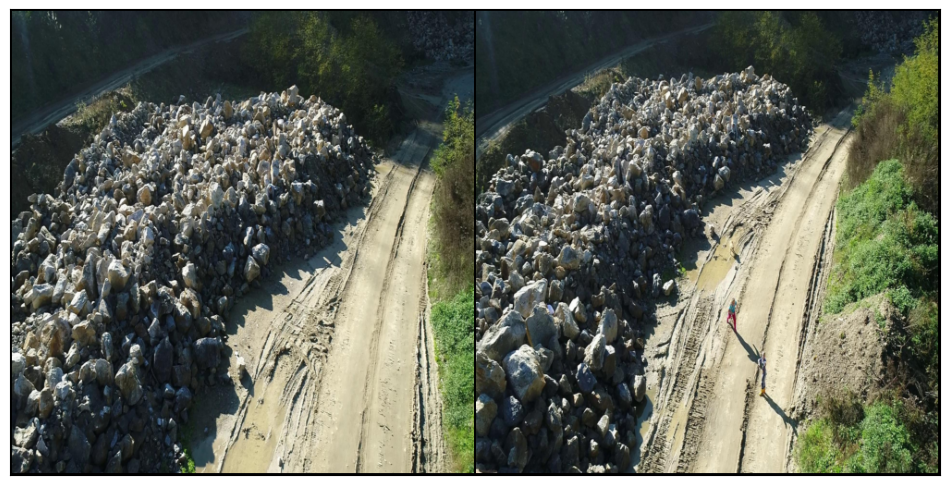

In [55]:
image_1 = read_image(str(Path('./SARD YOLO v1 YOLOv8/test/images/gss20_jpg.rf.047589c9390050179e79ef245c5c58e8.jpg')))
image_2 = read_image(str(Path('./SARD YOLO v1 YOLOv8/test/images/gss15_jpg.rf.2393804064c2f05b29994da3f902593c.jpg')))
image_list = [T.Resize(size=(500,500))(image_1), T.Resize(size=(500,500))(image_2)]
grid = make_grid(image_list) # return a tensor containing a grid of images
show(grid)

In [58]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights, progress=False).to(device)
model = model.eval()

In [59]:
transforms = weights.transforms()
images = [transforms(d).to(device) for d in image_list]
for image in images:
  print(image.shape)

torch.Size([3, 500, 500])
torch.Size([3, 500, 500])


In [60]:
output = model(images) # list of dict
print(len(output)) # equals to how many images that were fed into the model
print(output[0].keys()) # dict_keys(['boxes', 'labels', 'scores', 'masks'])
def inspect_model_output(output):
  for index,prediction in enumerate(output):
    print(f'Input {index + 1} has { len(prediction.get("scores")) } detected instances')

2
dict_keys(['boxes', 'labels', 'scores', 'masks'])


In [61]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

def filter_model_output(output,score_threshold):
  filtred_output = list()
  for image in output:
    filtred_image = dict()
    for key in image.keys():
      filtred_image[key] = image[key][image['scores'] >= score_threshold]
    filtred_output.append(filtred_image)
  return filtred_output

def get_boolean_mask(output):
  for index,pred in enumerate(output):
    output[index]['masks'] = pred['masks'] > 0.5
    output[index]['masks'] = output[index]['masks'].squeeze(1)
  return output

/Users/hima/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


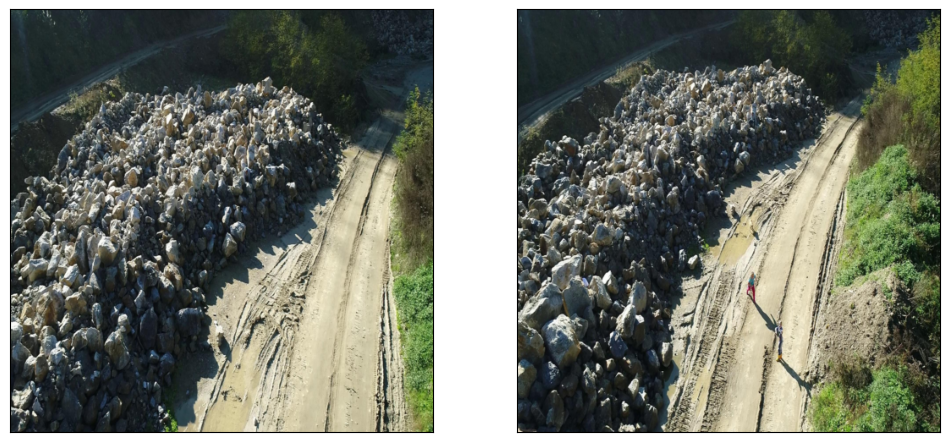

In [62]:
score_threshold = .8
output = filter_model_output(output=output,score_threshold=score_threshold)
output = get_boolean_mask(output)
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])